In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
cd /content/drive/MyDrive/Projet_TM/hULMonA

/content/drive/MyDrive/Projet_TM/hULMonA


In [ ]:
#from fastai.data.all import *
#from fastai.imports import *
from fastai import *
from fastai.text import *
from fastai.text.transform import * 
import fastai

In [ ]:
print(fastai.__version__)

1.0.64.dev0


In [ ]:
pip install fastai==1.0.61

In [ ]:
pip install spacy==2.2.4

In [ ]:
path = Path('.')
path.ls()

[PosixPath('fine_tune_LM.ipynb'),
 PosixPath('.git'),
 PosixPath('.gitignore'),
 PosixPath('README.md'),
 PosixPath('data'),
 PosixPath('models'),
 PosixPath('resources'),
 PosixPath('arabic-wiki-stuff.ipynb'),
 PosixPath('build_arabic_language_model.ipynb'),
 PosixPath('Untitled0.ipynb')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## prepare data for MADAMIRA

In [ ]:
import string

#preparing punctuations list
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ«»'''
english_punctuations = string.punctuation
punc_to_remove = ''.join(set(arabic_punctuations + english_punctuations))
punc_to_keep = '+'
punc_to_escape = '''[]-^'''
for p in punc_to_keep: punc_to_remove = punc_to_remove.replace(p, '')
for p in punc_to_escape: punc_to_remove = punc_to_remove.replace(p, '\\{}'.format(p))
print(punc_to_remove)

def pre_process(text):
    text = text.replace('\\n', ' ').replace('\n', ' ')
    text = text.replace('؛', '،')
    text = re.sub(r'\([^)]+\)', '', text)  # remove parentheses and everything in between
    text = re.sub(r'[a-zA-Z]', '', text)  # remove non-arabic characters
    text = re.sub(r'\d+(\.\d+)?', ' رقم ', text)  # replace numbers by special token
    for p in punc_to_remove: text = text.replace(p, '')  # remove punctuations
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # remove repeated chars
    text = re.sub(r'\s+', r' ', text)
    return text

\^=/«“:–؟_;"@`\-&*)÷\'؛،¦×?»<{\[!(#}ـ$%>”.,~\]|…


In [ ]:
df = pd.read_csv(path/'data'/'arabic_categorization_data.csv')
df.head()

#with open(path/'data'/'ASTD-B.csv', encoding='Windows-1256') as file:
#    print(file.readlines()[:5])

In [ ]:
df.polarity.value_counts() # balanced

In [ ]:
df.text.to_csv(path/'data'/'arabic_categorization_text_only.txt', header=False, index=False)

MADAMIRA...

In [ ]:
df_mada = pd.read_csv(path/'data'/'arabic_categorization_text_only.txt', sep='\t', header=None, names=['processed_text'])
df_mada.head()

In [ ]:
df['text'] = df_mada.processed_text
df.to_csv(path/'data'/'arabic_categorization_final.csv', index=False)

## Fine-Tune pre-trained LM

In [ ]:
pretrained_fnames=['Ar-LM-epoch1-acc43','itos']

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(path/'data'/'arabic_categorization_final.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
print(df.shape)
#df.dropna(inplace=True)
#print(df.shape)
#df.Tweet = df.Tweet.apply(lambda x: pre_process(x))
#df.label.replace({'very_positive':2, 'positive':1, 'neutral':0, 'negative':-1, 'very_negative':-2}, inplace=True)
np.random.seed(42)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape, df_val.shape)
#df.columns
df_train.head()

(10366, 2)
(8292, 2) (2074, 2)


,text,type
7136,\nأفاد مدير عام الامتحانات بوزارة التربية، عمر...,localnews
5120,\nتمكّنت، أمس الثلاثاء 18 أفريل 2017، فرقة الأ...,society
9959,\nتمكن أعوان مركز الأمن الوطني بالوردانين ليلة...,localnews
1817,\nأدانت تونس بشدة الإعتداء الإرهابي الجبان الذ...,internationalNews
1937,\nقدم وزير العدل الهولندي أرد فان دير ستيور اس...,internationalNews


In [ ]:
df_train.type.value_counts()

In [ ]:
df_val.Category.value_counts()

In [ ]:
df_train.info()

In [ ]:
df.isnull().sum()

In [ ]:
ar_tok = Tokenizer(lang='ar')
data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_val, text_cols=0, label_cols=None, tokenizer=ar_tok, bs=64, include_bos=False, min_freq=4)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.train_ds.x

In [ ]:
data_lm.show_batch()

In [ ]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2, pretrained_fnames=pretrained_fnames,config=config)

In [ ]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [ ]:
learn_lm.fit_one_cycle(1, 5e-2)

In [ ]:
learn_lm.save('learn_lm_arabic_categori_epoch1_acc272')

In [ ]:
learn_lm.unfreeze()

In [ ]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [ ]:
learn_lm.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3))

In [ ]:
learn_lm.save_encoder('fine_tuned_encoder_arabic_categori_acc326_min4')
# 3.935220	4.281686	0.295004

In [ ]:
learn_lm.predict('الله يبارك في +ك ', n_words=30)

## Classifier

In [ ]:
ar_tok = Tokenizer(lang='ar')
data_clas = TextClasDataBunch.from_df(path, train_df=df_train, valid_df=df_val, text_cols=0, label_cols=1, tokenizer=ar_tok, bs=32, vocab=data_lm.train_ds.vocab, include_bos=False, min_freq=4)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
del config['tie_weights']
del config['out_bias']
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.2, metrics=[accuracy,FBeta(average='weighted')])
learn_clas.load_encoder('/content/drive/MyDrive/Projet_TM/hULMonA/models/fine_tuned_encoder_arabic_categori_acc326_min4')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8292 items)
x: TextList
 
  أفاد مدير عام الامتحانات بوزارة التربية ، عمر الولباني ، أنه سيتم خلال دورة 2017 لامتحان الباكالوريا تركيز تقنيات أكثر xxunk xxunk من التقنيات المعتمدة في الدورات السابقة ، وذلك لمزيد xxunk الاختبارات الوطنية من عمليات الغش الالكتروني . 
  وأضاف ، الولباني ، في تصريح xxunk " ، الاربعاء ، أن " هذا الاجراء يهدف الى تضييق الخناق على هذا النوع من الغش والتصدي لكل المظاهر التي من شأنها أن تخل xxunk العادي للامتحانات الوطنية ، وتحقيق xxunk في النجاح بين مختلف xxunk وأشار ، في السياق ذاته ، الى أن " الوزارة انطلقت في اعتماد هذا التوجه منذ سنتين الامر الذي ساهم بشكل كبير في تراجع مثل هذه المحاولات في السنوات الفارطة " مبينا أن " الوزارة حريصة على أن تبقى مواضيع الامتحانات أداة قيس صادقة xxunk تعكس المستوى xxunk للتلميذ بعيدا عن xxunk 
 , 
  تمكّنت ، أمس الثلاثاء 18 أفريل 2017 ، فرقة الأبحاث والتفتيش للحرس الوطني بالتضامن ( ولاية أريانة ) من إلقاء القبض أحد المنحرفين بعد نصب كمين محكم ، بحسب بلاغ صادر عن وزارة الد

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


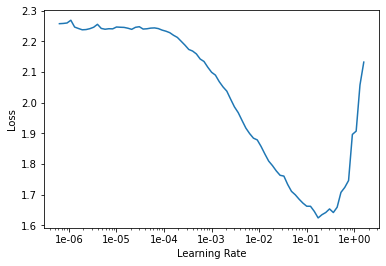

In [ ]:
learn_clas.lr_find()
learn_clas.recorder.plot()

In [ ]:
learn_clas.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.753596,0.623381,0.757473,0.751321,00:28


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn_clas.save('arabic_catego_first_acc7483_f643')

In [ ]:
learn_clas.load('arabic_catego_first_acc7483_f643')

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


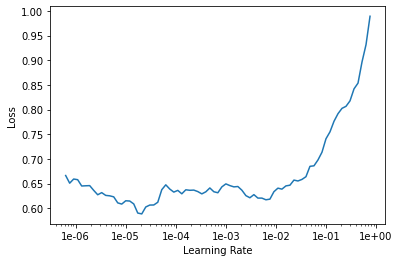

In [ ]:
learn_clas.freeze_to(-2)
learn_clas.lr_find()
learn_clas.recorder.plot()
#learn_clas.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2))

In [ ]:
# to be deleted
learn_clas.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.650340,0.620668,0.764706,0.758260,00:31


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
pred_class1,pred_idx,outputs=learn_clas.predict(" أحمد جمال الدين القيادي بحزب مصر")

In [ ]:
print(learn_clas.data.classes[to_data(pred_class1)])

politic


### Results
|Dataset|epoch|train_loss|valid_loss|accuracy|f_beta  |seed|test split|
|-------|-----|----------|----------|--------|--------|----|----------|
|ASTD-B |6	  |0.438674  |0.448438  |0.864662|0.857988|42  |0.1       |
|ASTD   |6	  |0.659341  |0.857126  |0.698801|0.677395|42  |0.2       |
|AJGT   |5    |0.429798	 |0.452757	|0.805556|0.745665|14  |0.2       |
|LEV    |16   |1.185471  |1.251261  |0.523750|0.511322|14  |0.2       |
|HARD   |7    |0.121737  |0.128373  |0.956695|0.956682|43  |0.2       |